In [162]:
##vocab test script
#imports
import multiprocessing
from multiprocessing import Pool
import math, random, sys
import pickle
import argparse
from functools import partial
import torch
import numpy
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from hgraph import MolGraph, common_atom_vocab, PairVocab
import rdkit
import rdkit.Chem as Chem
import networkx as nx
from hgraph.chemutils import *
from hgraph.nnutils import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import time
from rdkit.Chem import Draw

In [2]:
#process from get_vocab.py
def process(data):
    vocab = set()
    for line in data:
        s = line.strip("\r\n ")
        hmol = MolGraph(s)
        for node,attr in hmol.mol_tree.nodes(data=True):
            smiles = attr['smiles']
            vocab.add( attr['label'] )
            for i,s in attr['inter_label']:
                vocab.add( (smiles, s) )
    return vocab

In [3]:
#manual vocab import
with open('data/chembl/cyclic_peptide_smiles.txt') as f:
    contents = f.readlines()
print(contents[:5])

['N[C@@H]([C@]([H])(O)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](C(C)C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC1=CN=C-N1)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N1[C@@H](CCC1)C(=O)O\n', 'N[C@@H]([C@]([H])(O)C)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](C(C)C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC1=CN=C-N1)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O\n', 'N[C@@H]([C@]([H])(O)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](C(C)C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC1=CN=C-N1)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CS3)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O\n', 'N[C@@H](CCCCN)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1c

In [4]:
data = [mol.split()[:2] for mol in contents] #drop new line token
data = np.hstack(data)
data = list(set(data)) #prevent duplicates
print(data[:5])

['N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CC1=CN=C-N1)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(=O)N)C(=O)N[C@@H](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O', 'N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N1[C@@H](CCC1)C(=O)O', 'N[C@@H](C(C)C)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CS4)C(=O)N[C@@H](CO)C(=O)O', 'N[C@@H]([H])C(=O)N[C@@H](CSCC(C3)=O)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H]([C@]([H])(CC)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C4)=O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O', 'N[C@@H](C(C)C)C

In [5]:
vocab = set()
for line in data[:1]:
    hmol = MolGraph(line)
    for node,attr in hmol.mol_tree.nodes(data=True):
        print(node)
        print(attr)

0
{'ismiles': 'C[NH2:1]', 'inter_label': [(0, 'C[NH2:1]')], 'smiles': 'CN', 'label': ('CN', 'C[NH2:1]'), 'cluster': (0, 1), 'assm_cands': []}
1
{'ismiles': 'C[CH3:1]', 'inter_label': [(1, 'C[CH3:1]')], 'smiles': 'CC', 'label': ('CC', 'C[CH3:1]'), 'cluster': (1, 2), 'assm_cands': []}
2
{'ismiles': 'C[CH3:1]', 'inter_label': [(2, 'C[CH3:1]')], 'smiles': 'CC', 'label': ('CC', 'C[CH3:1]'), 'cluster': (2, 3), 'assm_cands': []}
3
{'ismiles': 'C[CH3:1]', 'inter_label': [(3, 'C[CH3:1]')], 'smiles': 'CC', 'label': ('CC', 'C[CH3:1]'), 'cluster': (3, 4), 'assm_cands': []}
4
{'ismiles': 'N[CH3:1]', 'inter_label': [(4, 'N[CH3:1]')], 'smiles': 'CN', 'label': ('CN', 'N[CH3:1]'), 'cluster': (4, 5), 'assm_cands': []}
5
{'ismiles': 'C[NH2:1]', 'inter_label': [(5, 'C[NH2:1]')], 'smiles': 'CN', 'label': ('CN', 'C[NH2:1]'), 'cluster': (5, 6), 'assm_cands': []}
6
{'ismiles': 'N=[CH2:1]', 'inter_label': [(6, 'N=[CH2:1]')], 'smiles': 'C=N', 'label': ('C=N', 'N=[CH2:1]'), 'cluster': (6, 7), 'assm_cands': []}
7

In [8]:
clusters, atom_cls = MolGraph('CC(C)(C)P1=COB=N1').find_clusters()
clusters #clusters are the atoms connected by bonds, grouped as more than pairs if it's part of a ring

[(0, 1), (1, 2), (1, 3), (1, 4), (4, 5, 6, 7, 8)]

In [9]:
atom_cls #atom_cls tells you which atoms are part of which bonds (clusters)

[[0], [0, 1, 2, 3], [1], [2], [3, 4], [4], [4], [4], [4]]

In [10]:
#build a graph from the molecule components
graph = nx.empty_graph( len(clusters) )
for atom,nei_cls in enumerate(atom_cls):
    if len(nei_cls) <= 1: #is this atom only attached to one other atom? if so, skip this atom
        continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2
    if len(nei_cls) > 2 and len(bonds) >= 2:
        clusters.append([atom])
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)

    elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
        clusters.append([atom]) #temporary value, need to change
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)
    else:
        for i,c1 in enumerate(nei_cls):
            for c2 in nei_cls[i + 1:]:
                inter = set(clusters[c1]) & set(clusters[c2])
                graph.add_edge(c1, c2, weight = len(inter))

In [11]:
#test with one atom that's connected to more than one atom, but not part of a ring
print(atom_cls[1:2])
graph = nx.empty_graph( len(clusters) )
for atom,nei_cls in enumerate(atom_cls[1:2]):
    if len(nei_cls) <= 1: #is this atom only attached to one other atom? if so, skip this atom
        continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2
    
    
print(bonds)
print(rings)

[[0, 1, 2, 3]]
[0, 1, 2, 3]
[]


In [12]:
#test with one atom that's connected to more than one atom and is part of a ring
print(atom_cls[4:5])
graph = nx.empty_graph( len(clusters) )
for atom,nei_cls in enumerate(atom_cls[4:5]):
    if len(nei_cls) <= 1: #is this atom only attached to one other atom? if so, skip this atom
        continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2
    
    
print(bonds)
print(rings)

[[3, 4]]
[3]
[4]


In [13]:
clusters, atom_cls = MolGraph('CC(C)(C)P1=COB=N1').find_clusters()
graph = nx.empty_graph( len(clusters) )
for atom_index,atoms_connected in enumerate(atom_cls):
    if len(atoms_connected) <= 1: #is this atom only attached to one other atom? if so, skip this atom
        continue
    bonds = [c for c in atoms_connected if len(clusters[c]) == 2]
    rings = [c for c in atoms_connected if len(clusters[c]) > 4] #need to change to 2

    
    if len(atoms_connected) > 2 and len(bonds) >= 2: #if the atom is connected to more than 2 atoms, has more than one bond (and is therefore not part of a ring?)
        print('atom is connected to other non-ring atoms')
        print('atom index: ' + str(atom_index))
        print('connected atom indices: ' + str(atoms_connected))
        print('indices of bonds from clusters: ' + str(bonds))
        print('indices of rings from clusters: ' + str(rings))
        clusters.append([atom_index])
        print('new cluster vector: ' + str(clusters))
        c2 = len(clusters) - 1
        print('name of new graph node: ' + str(c2))
        graph.add_node(c2)
        for c1 in atoms_connected:
            graph.add_edge(c1, c2, weight = 100)

    elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
        clusters.append([atom_index]) #temporary value, need to change
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in atoms_connected:
            graph.add_edge(c1, c2, weight = 100)
    else:
        print('other atom')
        print('atom index: ' + str(atom_index))
        print('connected atom indices: ' + str(atoms_connected))
        print('indices of bonds from clusters: ' + str(bonds))
        print('indices of rings from clusters: ' + str(rings))
        for i,c1 in enumerate(atoms_connected):
            for c2 in atoms_connected[i + 1:]:
                inter = set(clusters[c1]) & set(clusters[c2])
                graph.add_edge(c1, c2, weight = len(inter))

atom is connected to other non-ring atoms
atom index: 1
connected atom indices: [0, 1, 2, 3]
indices of bonds from clusters: [0, 1, 2, 3]
indices of rings from clusters: []
new cluster vector: [(0, 1), (1, 2), (1, 3), (1, 4), (4, 5, 6, 7, 8), [1]]
name of new graph node: 5
other atom
atom index: 4
connected atom indices: [3, 4]
indices of bonds from clusters: [3]
indices of rings from clusters: [4]


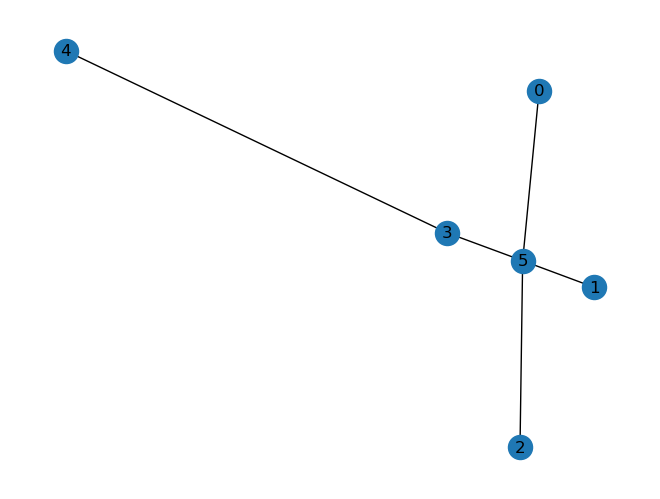

In [14]:
nx.draw(graph,with_labels=True)
plt.show()

In [15]:
mol = get_mol('CC(C)(C)P1=COB=N1')
n_atoms = mol.GetNumAtoms()
if n_atoms == 1: #special case
    output = [(0,)], [[0]]

clusters = []
#this for loop adds clusters for all non-ring atoms
for bond in mol.GetBonds():
    print(bond)
    a1 = bond.GetBeginAtom().GetIdx() #atom index for the start of the bond
    a2 = bond.GetEndAtom().GetIdx() #atom index for the end of the bond
    print(bond.GetBeginAtom().GetAtomicNum())
    print(bond.GetEndAtom().GetAtomicNum())
    if not bond.IsInRing():
        clusters.append( (a1,a2) )

# ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
# clusters.extend(ssr)

# if 0 not in clusters[0]: #root is not node[0]
#     for i,cls in enumerate(clusters):
#         if 0 in cls:
#             clusters = [clusters[i]] + clusters[:i] + clusters[i+1:]
#             #clusters[i], clusters[0] = clusters[0], clusters[i]
#             break

# atom_cls = [[] for i in range(n_atoms)]
# for i in range(len(clusters)):
#     for atom in clusters[i]:
#         atom_cls[atom].append(i)

print(clusters)

6
6
6
6
6
6
6
15
15
6
6
8
8
5
5
7
7
15
[(0, 1), (1, 2), (1, 3), (1, 4)]


In [16]:
def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

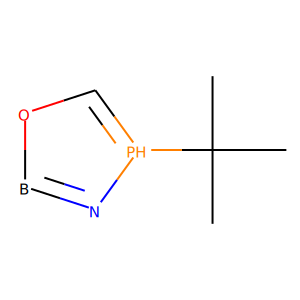

In [17]:
SVG(moltosvg(mol))

In [18]:
mol.GetSubstructMatch()

TypeError: _GetSubstructMatch() missing 1 required positional argument: 'query'

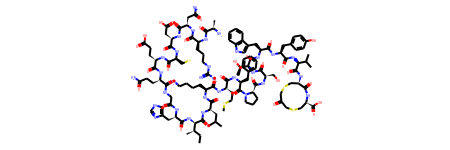

In [81]:
peptide = 'OC(C[C@H](NC([C@H](CC(N)=O)NC([C@H](CCCNC(N)=N)NC([C@@H](N[H])C)=O)=O)=O)C(N[C@@H](CS[H])C(N[C@@H](CCC(O)=O)C(N[C@@H](CCC(N)=O)C(NCC(N[C@@H](CC1=CNC=N1)C(N[C@@](C(N[C@H](C(N[C@@H](CCCCN[H])C(N[C@@H](CCSC)C(N[C@H](C(N2CCC[C@H]2C(N[C@@H](CO)C(N[C@@]([H])([C@@H](C)O)C(N[C@@H](CC3=CNC4=C3C=CC=C4)C(N[C@@H](CC(C=C5)=CC=C5O)C(N[C@@H](C(C)C)C(N[C@@H](CSCC6=O)C(N[C@@H](CSC6)C(O)=O)=O)=O)=O)=O)=O)=O)=O)=O)CC7=CC=CC=C7)=O)=O)=O)CC(C)C)=O)([H])[C@H](CC)C)=O)=O)=O)=O)=O)=O)=O'
peptide = get_mol(peptide)
peptide

In [56]:
match_molecule = 'O=CN[C@H3]'
matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(match_molecule),useChirality=True)
matches

((26, 22, 21, 13),
 (27, 12, 11, 6),
 (28, 5, 4, 3),
 (150, 141, 142, 143),
 (151, 133, 134, 135),
 (152, 127, 128, 129),
 (153, 116, 117, 118),
 (154, 103, 104, 105),
 (155, 97, 98, 99),
 (156, 92, 93, 94),
 (157, 86, 87, 88),
 (157, 86, 87, 91),
 (165, 83, 84, 85),
 (166, 76, 77, 78),
 (167, 68, 69, 70),
 (172, 65, 66, 67),
 (177, 62, 63, 64),
 (178, 53, 54, 55),
 (179, 50, 51, 52),
 (180, 42, 43, 44),
 (181, 34, 35, 36),
 (182, 29, 30, 31))

In [170]:
##recursively identify alpha carbons, and map the atom indices that contain their side chains

backbone_atoms = np.array(matches).reshape((22,4))
c_alphas = backbone_atoms[:,3]
#atoms[:,0] are carbonyl oxygens
#atoms[:,1] are sp2-carbons with carbonyls
#atoms[:,2] are nitrogens
#atoms[:,3] are functional group holding carbons
backbone_atoms = np.hstack(np.array(backbone_atoms))
c_alphas
print([peptide.GetAtomWithIdx(int(x)).GetAtomicNum() for x in c_alphas])

c_alphas_neighbors = [peptide.GetAtomWithIdx(int(x)).GetNeighbors() for x in c_alphas]

for index,c_alpha in enumerate(c_alphas):
    c_alpha_neighbors = peptide.GetAtomWithIdx(int(c_alpha)).GetNeighbors()
    print('starting c_alpha atom index: ' + str(c_alpha))
    # print('neighbor indices: ' +str([neighbor.GetIdx() for neighbor in c_alpha_neighbors]))
    # print('neighbor atomic masses: ' + str([neighbor.GetAtomicNum() for neighbor in c_alpha_neighbors]))
    # print('starting atoms: ' + str([c_alpha_neighbor.GetIdx() for c_alpha_neighbor in c_alpha_neighbors]))
    for neighbor in c_alpha_neighbors:
        if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
            # print('starting side chain atom: '+str(neighbor.GetIdx()) + ', atomic num: ' + str(neighbor.GetAtomicNum()))
            side_chain_atoms = np.array([neighbor.GetIdx()])
            new_neighbors = neighbor.GetNeighbors()
            # print('starting neighbor atom(s): ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]) + ', atomic num(s): ' + str([new_neighbor.GetAtomicNum() for new_neighbor in new_neighbors]))
            atoms_to_examine = np.array([])
            while(len(new_neighbors) > 0):
                for new_neighbor in new_neighbors:
                    if (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms):
                        # print('new neighbor atom found, index: ' + str(new_neighbor.GetIdx()))
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                        # print('side_chain_atom(s): ' + str(side_chain_atoms))
                        atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                        # print('atom(s) to examine: ' + str(atoms_to_examine))
                    elif new_neighbor.GetIdx()  in side_chain_atoms:
                        print('already found this atom in side chain: ' + str(new_neighbor.GetIdx()))
                    elif new_neighbor.GetIdx() in backbone_atoms:
                        print('already found this atom in back bone: ' + str(new_neighbor.GetIdx()))
                if len(atoms_to_examine) == 0:
                    print('no new atoms to explore')
                    break
                else:
                    new_neighbors = np.hstack([peptide.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine])
                    # print('new neighbors to investigate: ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]))
                    atoms_to_examine = np.array([])
            print('complete mapped side chain: ' + str([x for x in side_chain_atoms]))
    #neighbors are not in a consistent order


# [peptide.GetAtomWithIdx(x).GetNeighbors() for x in c_alphas]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
starting c_alpha atom index: 13
already found this atom in back bone: 13
already found this atom in side chain: 14
already found this atom in side chain: 15
already found this atom in side chain: 16
already found this atom in side chain: 17
already found this atom in side chain: 18
already found this atom in side chain: 18
no new atoms to explore
complete mapped side chain: [14, 15, 16, 17, 18, 19, 20]
starting c_alpha atom index: 6
already found this atom in back bone: 6
already found this atom in side chain: 7
already found this atom in side chain: 8
already found this atom in side chain: 8
no new atoms to explore
complete mapped side chain: [7, 8, 9, 10]
starting c_alpha atom index: 3
already found this atom in back bone: 3
already found this atom in side chain: 2
already found this atom in side chain: 1
already found this atom in side chain: 1
no new atoms to explore
complete mapped side chain: [2, 1, 0, 183]
starti

In [156]:
##recursively map the atom indices that contain their side chains (For a single side chain)

print('starting atoms: ' + str([c_alpha_neighbor.GetIdx() for c_alpha_neighbor in c_alpha_neighbors]))
for neighbor in c_alpha_neighbors:
    if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
        print('starting side chain atom: '+str(neighbor.GetIdx()) + ', atomic num: ' + str(neighbor.GetAtomicNum()))
        side_chain_atoms = np.array([neighbor.GetIdx()])
        new_neighbors = neighbor.GetNeighbors()
        print('starting neighbor atom(s): ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]) + ', atomic num(s): ' + str([new_neighbor.GetAtomicNum() for new_neighbor in new_neighbors]))
        atoms_to_examine = np.array([])
        while(len(new_neighbors) > 0):
            for new_neighbor in new_neighbors:
                if (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms):
                    print('new neighbor atom found, index: ' + str(new_neighbor.GetIdx()))
                    side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                    print('side_chain_atom(s): ' + str(side_chain_atoms))
                    atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                    print('atom(s) to examine: ' + str(atoms_to_examine))
                elif new_neighbor.GetIdx()  in side_chain_atoms:
                    print('already found this atom in side chain: ' + str(new_neighbor.GetIdx()))
                elif new_neighbor.GetIdx() in backbone_atoms:
                    print('already found this atom in back bone: ' + str(new_neighbor.GetIdx()))
            if len(atoms_to_examine) == 0:
                print('no new atoms to explore')
                break
            else:
                new_neighbors = np.hstack([peptide.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine])
                print('new neighbors to investigate: ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]))
                atoms_to_examine = np.array([])
                time.sleep(1)
        print('complete mapped side chain: ' + str([x for x in side_chain_atoms]))

starting atoms: [30, 32, 34]
starting side chain atom: 32, atomic num: 6
starting neighbor atom(s): [31, 33], atomic num(s): [6, 16]
already found this atom in back bone: 31
new neighbor atom found, index: 33
side_chain_atom(s): [32 33]
atom(s) to examine: [33.]
new neighbors to investigate: [32]
already found this atom in side chain: 32
no new atoms to explore
complete mapped side chain: [32, 33]


In [158]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

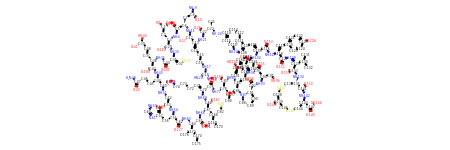

In [159]:
mol_with_atom_index(peptide)

In [168]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

AttributeError: module 'rdkit.Chem.Draw.IPythonConsole' has no attribute 'drawOptions'

In [167]:
Draw.MolToFile(peptide, "peptide.png",size=(6000,6000))